<a href="https://colab.research.google.com/github/juan-p-b/PerezJuanCarlos_RECV_Entrega6/blob/main/PerezJuanCarlos_RECV_Entrega6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting y Regularización 

In [ ]:
!unzip mnist.zip

In [6]:
import numpy as np 
import matplotlib.pyplot as plt

In [7]:
from glob import glob

from PIL import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [8]:
train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )


N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )


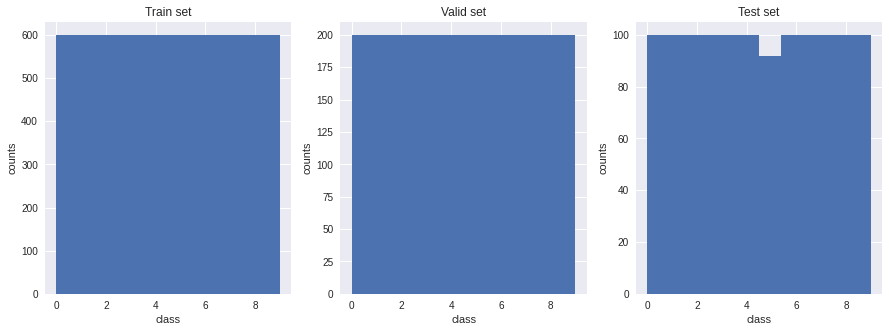

In [10]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

In [11]:
#--- Tensores
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [12]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

In [13]:
from sklearn.metrics import f1_score


#---- Entrenamiento del modelo

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  #CM(Y_valid, Y_pred, 10)
  return loss_valid[-1], f1_valid[-1], acc_valid[-1]


In [14]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm

#--- Se definen los dos modelos a probar
def models(index,hidden):
  input_dim = 28*28
  out_dim = 10
  #Retorna el modelo

    #-----Modelo 0------------
  model_0 = torch.nn.Sequential(
      torch.nn.Linear(input_dim, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, out_dim)
    )
  if index==0:
    return model_0
  if index==1:
    #-----Modelo 1------------
    model_1 = torch.nn.Sequential(
      torch.nn.Linear(input_dim, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, out_dim)
    )
    return model_1
  if index==2:
    #-----Modelo 2------------
    model_2 = torch.nn.Sequential(
      torch.nn.Linear(input_dim, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, out_dim)
    )
    return model_2
  if index==3:
    #-----Modelo 2------------
    model_2 = torch.nn.Sequential(
      torch.nn.Linear(input_dim, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, hidden),
      torch.nn.ReLU(),
      torch.nn.Linear(hidden, out_dim)
    )
    return model_2
  return model_0

def train_model(mdl):
  #---Barra de progreso
  pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))
  for ne in ne_list:
    for bs in bs_list:
      train_ds = TensorDataset(X_train, Y_train)
      train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
      for lr in lr_list:
        for wd in wd_list:
          for hd in hd_list:
            hidden = hd
            model = models(mdl,hd)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            criterion = torch.nn.CrossEntropyLoss()

            print('Modelo:{},ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(i,ne,hd,wd,lr,bs))
            loss_i,f1_i,acc_i = train_valid(model,ne,optimizer,criterion)
            print('###################\n')
            loss_list.append(loss_i)
            f1_list.append(f1_i)
            acc_list.append(acc_i)
            pbar.update()
  pbar.close()


In [15]:
loss_list = []
f1_list = []
acc_list = []


hd_list = [30]
#Número de epocas 
ne_list = [50,100,150]

#Batch size 
bs_list = [256,512,1024]

#Learning rate
lr_list = [0.001,0.01,0.1]

#Weight decay
wd_list = [0.001,0.01,0.1]


for i in range(3):
  train_model(i)
  print("Fin del modelo "+str(i))
  print("------------------------------------------------")

  0%|          | 0/81 [00:00<?, ?it/s]

Modelo:0,ne: 50, hd:30, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 1.1500474214553833. f1:0.6357609666679418 acc: 0.6470000147819519 
###################

Modelo:0,ne: 50, hd:30, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 1.0697393417358398. f1:0.7523259775285893 acc: 0.7549999952316284 
###################

Modelo:0,ne: 50, hd:30, wd:0.1, lr: 0.001, bs:256 
Valid Evaluation loss: 1.2625529766082764. f1:0.601471794597453 acc: 0.6330000162124634 
###################

Modelo:0,ne: 50, hd:30, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 1.942003607749939. f1:0.23057816931255215 acc: 0.2770000100135803 
###################

Modelo:0,ne: 50, hd:30, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 1.9787747859954834. f1:0.27797103991644706 acc: 0.3059999942779541 
###################

Modelo:0,ne: 50, hd:30, wd:0.1, lr: 0.01, bs:256 
Valid Evaluation loss: 2.275374412536621. f1:0.04618849649554254 acc: 0.11500000208616257 
###################

Modelo:0,ne: 50, hd:30, 

  0%|          | 0/81 [00:00<?, ?it/s]

Modelo:1,ne: 50, hd:30, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6405985951423645. f1:0.813508959980069 acc: 0.8149999976158142 
###################

Modelo:1,ne: 50, hd:30, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6393265724182129. f1:0.8281447627978358 acc: 0.828499972820282 
###################

Modelo:1,ne: 50, hd:30, wd:0.1, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6882567405700684. f1:0.8106707692409285 acc: 0.8105000257492065 
###################

Modelo:1,ne: 50, hd:30, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 1.2925645112991333. f1:0.5761792007855682 acc: 0.6119999885559082 
###################

Modelo:1,ne: 50, hd:30, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 1.0349550247192383. f1:0.6468365359503785 acc: 0.6625000238418579 
###################

Modelo:1,ne: 50, hd:30, wd:0.1, lr: 0.01, bs:256 
Valid Evaluation loss: 0.9802364110946655. f1:0.7116119966749157 acc: 0.7105000019073486 
###################

Modelo:1,ne: 50, hd:30, wd:

  0%|          | 0/81 [00:00<?, ?it/s]

Modelo:2,ne: 50, hd:30, wd:0.001, lr: 0.001, bs:256 
Valid Evaluation loss: 0.6584151983261108. f1:0.7959797577841102 acc: 0.7960000038146973 
###################

Modelo:2,ne: 50, hd:30, wd:0.01, lr: 0.001, bs:256 
Valid Evaluation loss: 0.5385016202926636. f1:0.8343514370346456 acc: 0.8345000147819519 
###################

Modelo:2,ne: 50, hd:30, wd:0.1, lr: 0.001, bs:256 
Valid Evaluation loss: 0.5127225518226624. f1:0.8457449617148987 acc: 0.8460000157356262 
###################

Modelo:2,ne: 50, hd:30, wd:0.001, lr: 0.01, bs:256 
Valid Evaluation loss: 1.5221410989761353. f1:0.38296255580049343 acc: 0.4494999945163727 
###################

Modelo:2,ne: 50, hd:30, wd:0.01, lr: 0.01, bs:256 
Valid Evaluation loss: 1.2720872163772583. f1:0.5175812038352641 acc: 0.593500018119812 
###################

Modelo:2,ne: 50, hd:30, wd:0.1, lr: 0.01, bs:256 
Valid Evaluation loss: 0.4965181350708008. f1:0.8409098665913625 acc: 0.8410000205039978 
###################

Modelo:2,ne: 50, hd:30, w

In [17]:
len(loss_list)

243

In [21]:
aloss_list = np.array(loss_list)
np.hsplit(aloss_list,3)

[array([1.15004742, 1.06973934, 1.26255298, 1.94200361, 1.97877479,
        2.27537441, 2.44605899, 2.30358911, 2.37622786, 0.99056411,
        1.19545388, 0.94894642, 1.96032679, 1.97538364, 2.10249233,
        2.24347115, 2.39857626, 2.25631976, 1.09485364, 0.87615269,
        1.46355855, 2.16738224, 2.09692168, 2.0259254 , 2.44828057,
        2.28089929, 2.25365615, 1.01284444, 0.80882764, 0.72321302,
        2.07663989, 1.86993015, 1.46659446, 2.12891221, 2.43610525,
        2.30279231, 0.78420389, 0.9717046 , 0.9266082 , 2.19797301,
        1.6841774 , 1.81358361, 2.30258703, 2.30282784, 2.30819774,
        0.8183254 , 0.72189879, 0.74956149, 1.82742417, 1.75934672,
        1.69669735, 2.18849349, 2.99642801, 2.33209014, 0.93734914,
        0.80506408, 0.66294158, 1.73140311, 1.78725266, 1.84992766,
        2.30258536, 2.30258751, 2.30009985, 0.74800676, 0.65958774,
        0.77219152, 2.07186294, 1.33141696, 1.6265794 , 2.3004117 ,
        2.28903031, 2.41354895, 0.77773303, 0.69

No handles with labels found to put in legend.


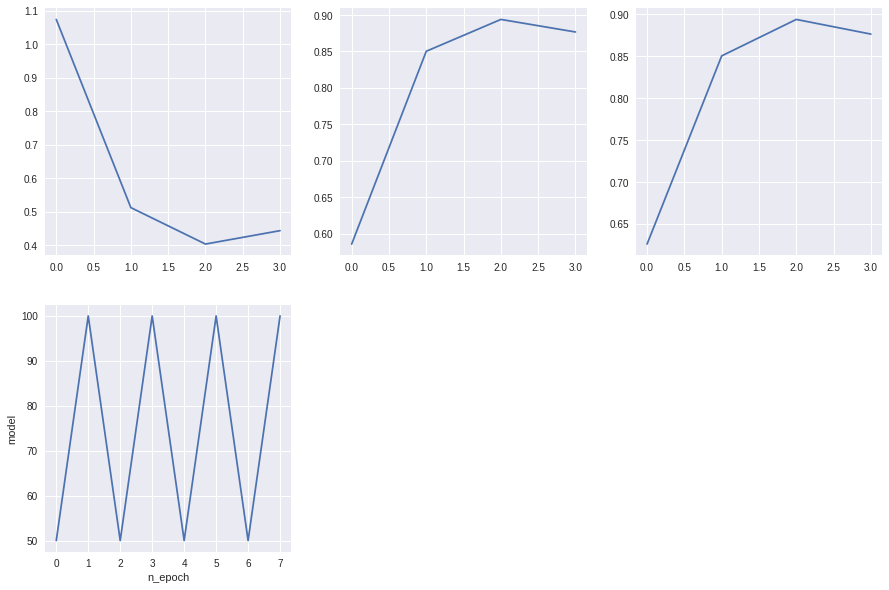

In [85]:
fig = plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
for ne in enumerate(ne_list):
plt.plot(loss_list)

plt.subplot(2,3,2)
plt.plot(f1_list)

plt.subplot(2,3,3)
plt.plot(acc_list)

plt.subplot(2,3,4)
plt.plot(ne_app)

plt.xlabel('n_epoch')
plt.ylabel('model')
plt.legend()

Se tienen entonces 3 modelos:
El primero, como modelo 0 es base de referencia con 2 capa. El modelo 1 cuenta con 3 capas y el model 2 con 4 capas.